In [2]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from pytorch_grad_cam import GradCAM
from torchvision.datasets import ImageFolder
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

In [3]:
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device="cuda")

predictor = SamPredictor(sam)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

# Crear los Datasets
train_dataset = ImageFolder(root="Final_dataset_small4", transform=transform)
#validation_dataset = ImageFolder(root="Final_dataset_small/Validation", transform=transform)

# Crear los DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
#validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [11]:
import torch.nn.functional as F

class MaskGenerator(nn.Module):
    def __init__(self):
        super(MaskGenerator, self).__init__()

        self.downsample = nn.AvgPool2d(3, stride=3, padding=1) # Para reducir la imagen de 224x224 a 64x64
        self.upsample = nn.Upsample((224, 224), mode='bilinear', align_corners=True) # Para ampliar la imagen de 64x64 a 224x224

        # Aquí definimos un modelo simple de una red convolucional.
        # Se puede reemplazar con una arquitectura más compleja si es necesario.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.downsample(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # El rango de la salida es [0, 1]
        x = self.upsample(x)

        return x


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.mask_generator = MaskGenerator()

        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(1280, 10)
        # Load pretrained model
        state_dict = torch.load('classifier.pth')
        new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        self.model.load_state_dict(new_state_dict)
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        mask = self.mask_generator(x)
        # Si mask > 0.5, mask = 1, sino mask = 0
        mask = torch.round(mask)
        x = x * mask
        

        # Plot mask

        x = self.model(x)

        return x

In [12]:
cuda = torch.device('cuda')
custom = CustomModel()
custom.to(device=cuda)
optimizer = optim.Adam(custom.parameters())
criterion = nn.CrossEntropyLoss()

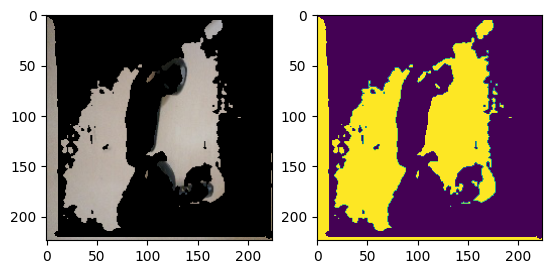

Epoch: 0 | Iteration: 0 | Loss: 5.526463031768799


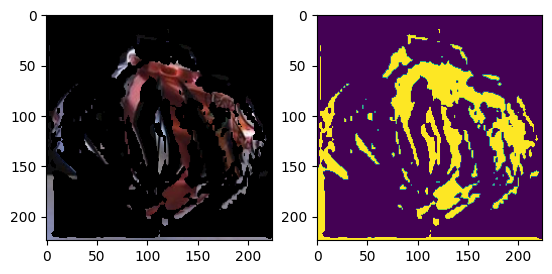

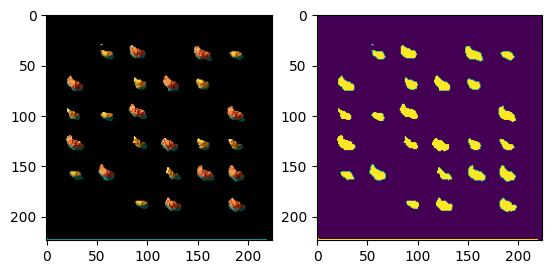

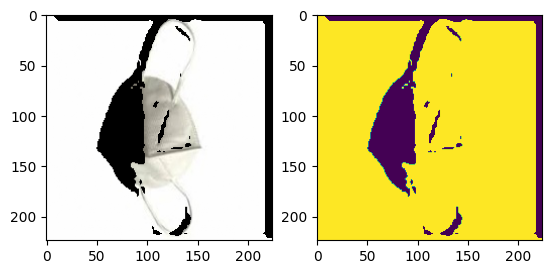

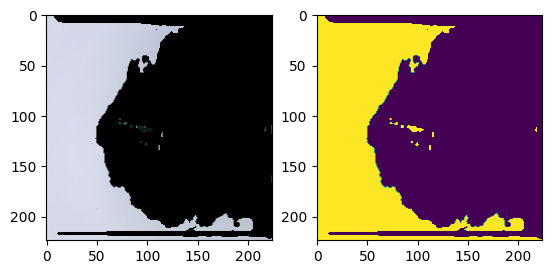

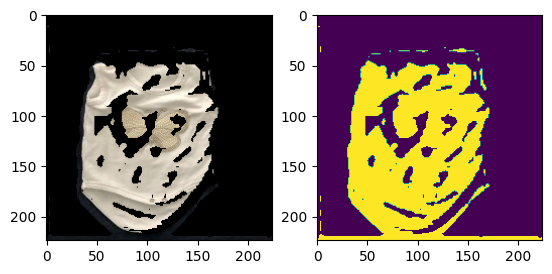

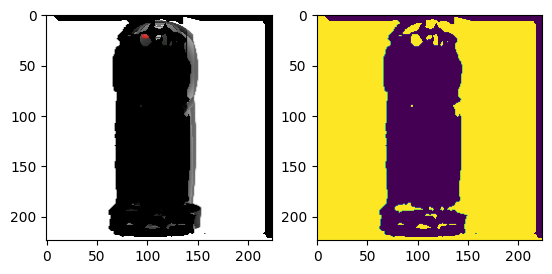

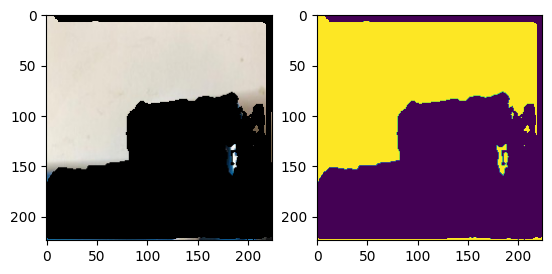

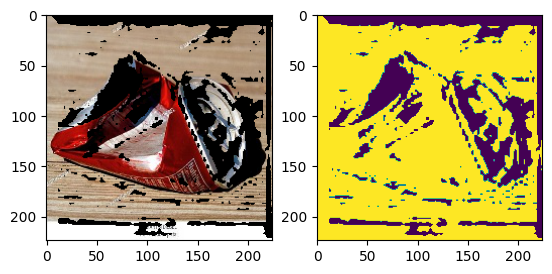

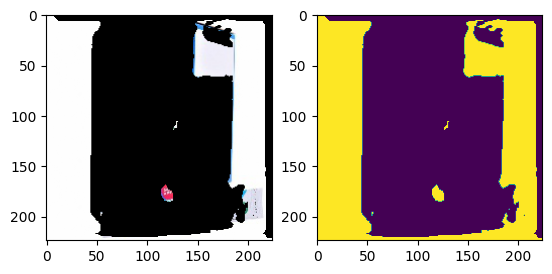

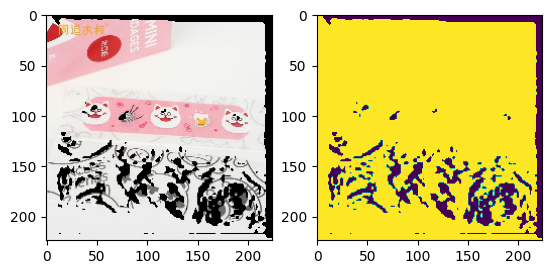

Epoch: 0 | Iteration: 10 | Loss: 5.9607415199279785


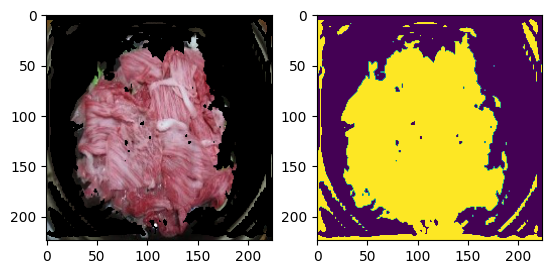

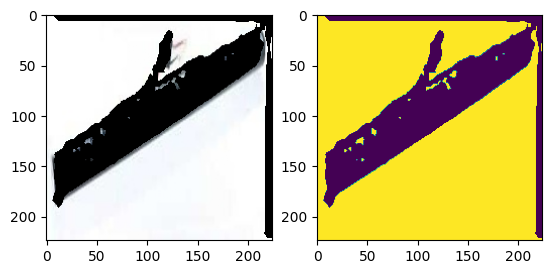

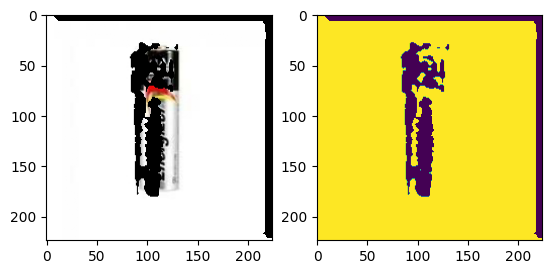

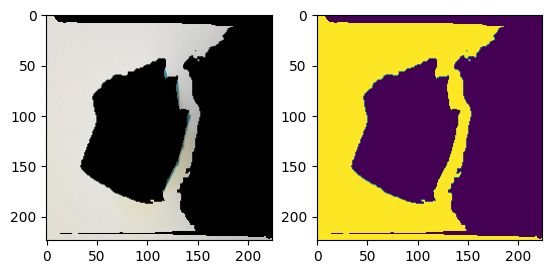

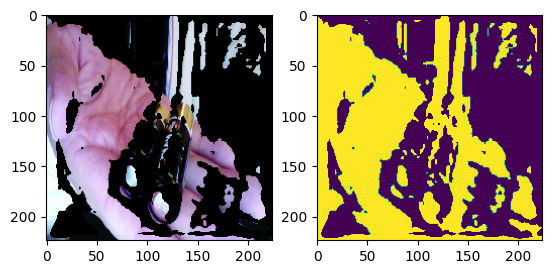

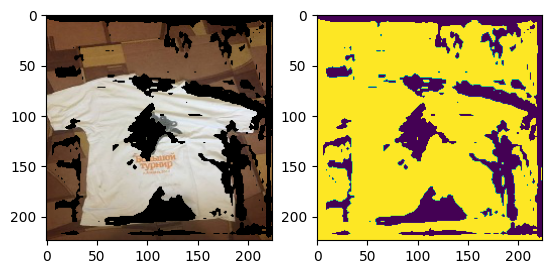

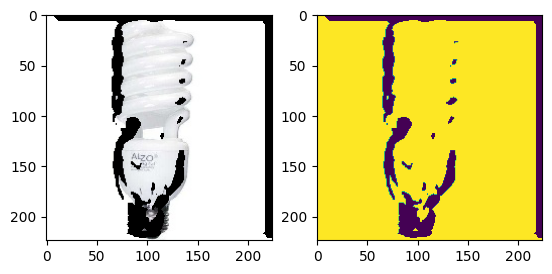

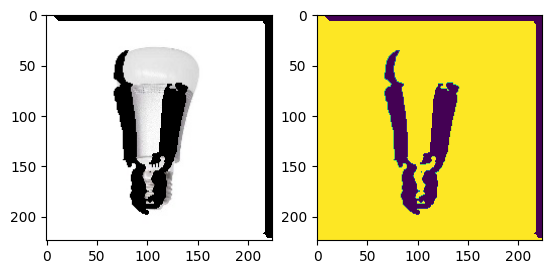

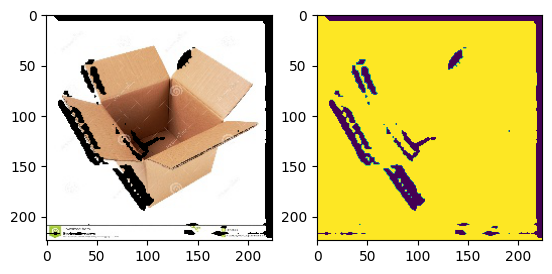

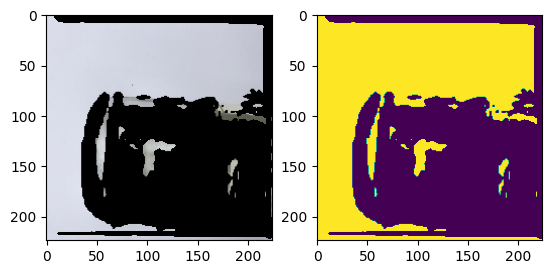

Epoch: 0 | Iteration: 20 | Loss: 7.086003303527832


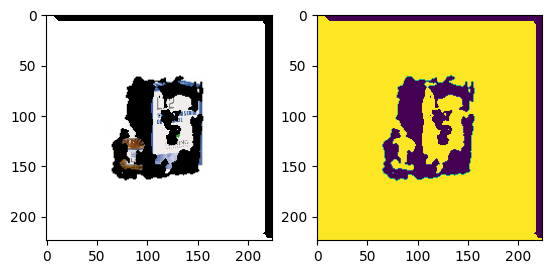

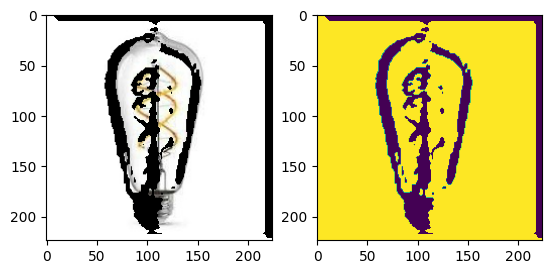

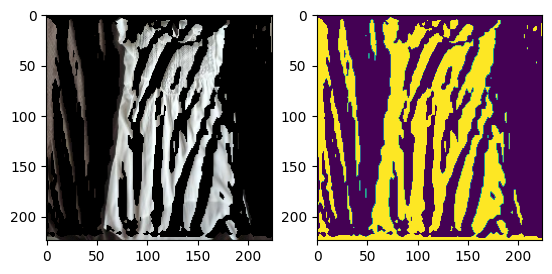

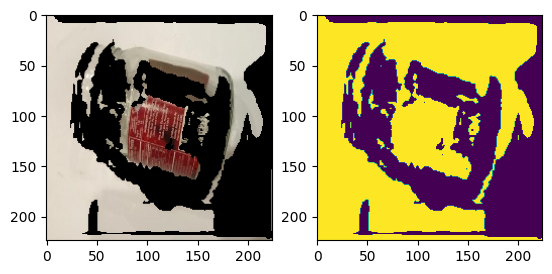

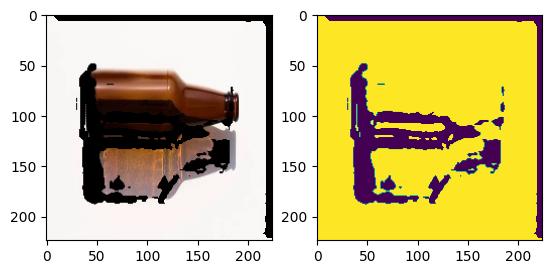

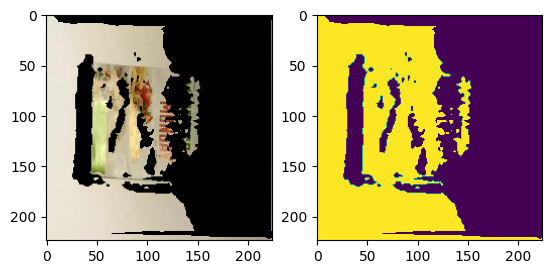

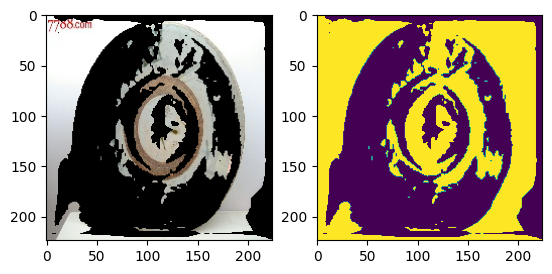

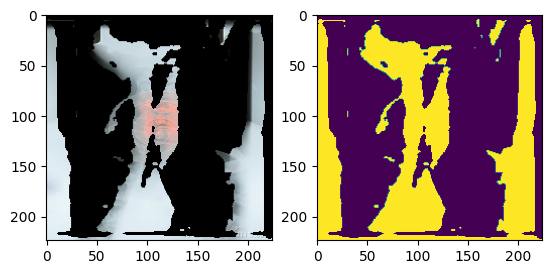

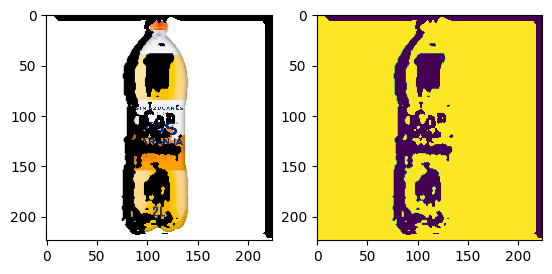

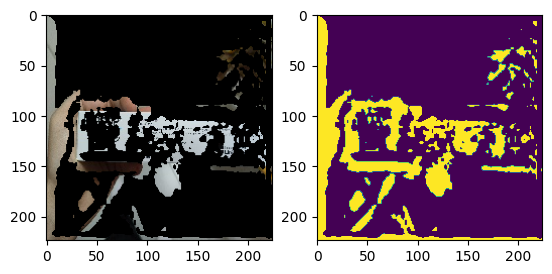

Epoch: 0 | Iteration: 30 | Loss: 4.50400447845459


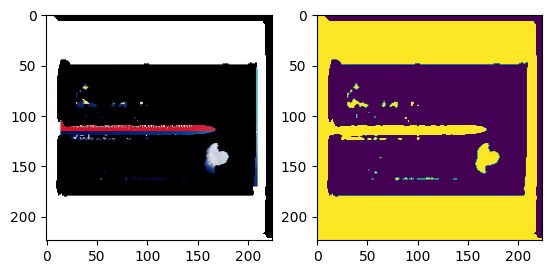

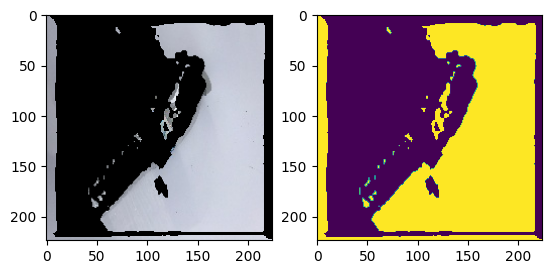

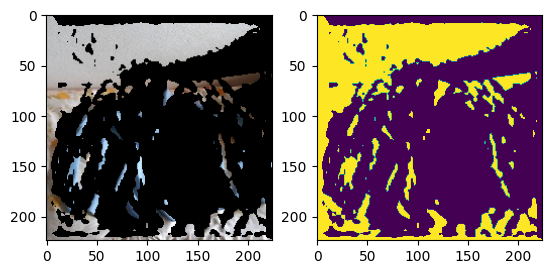

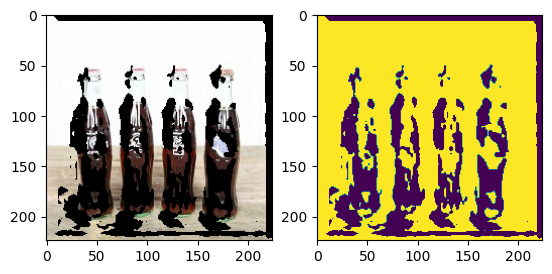

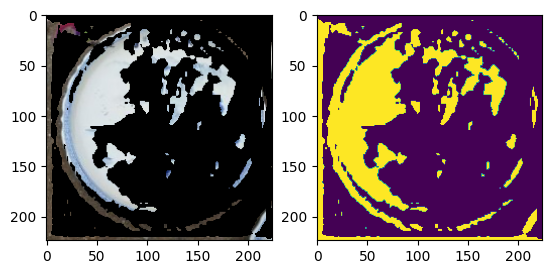

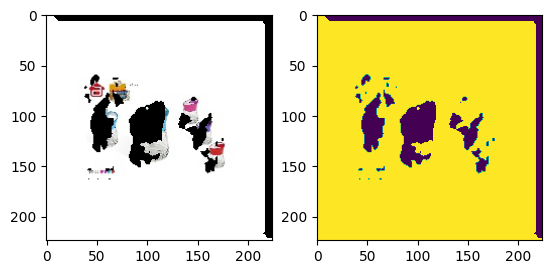

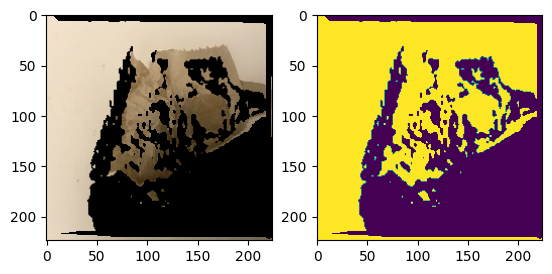

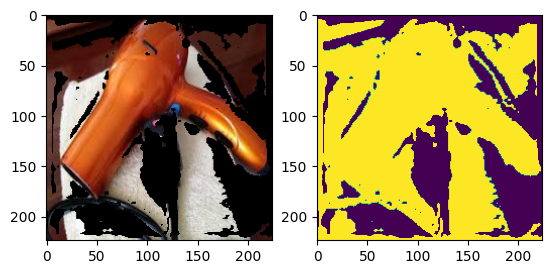

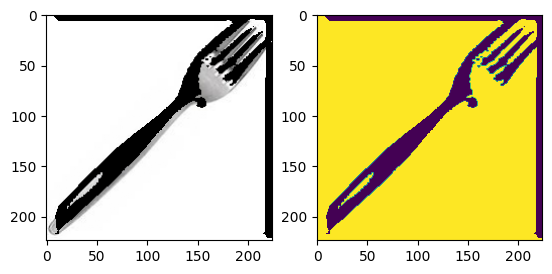

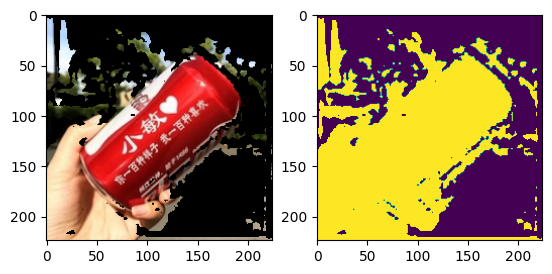

Epoch: 0 | Iteration: 40 | Loss: 5.385424613952637


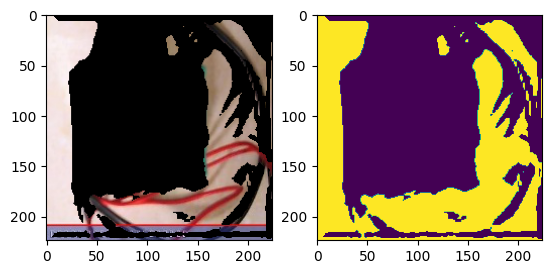

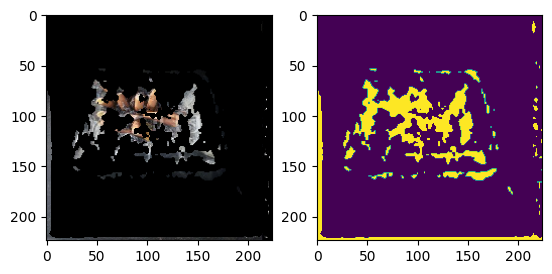

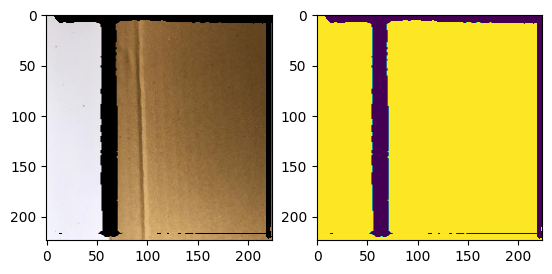

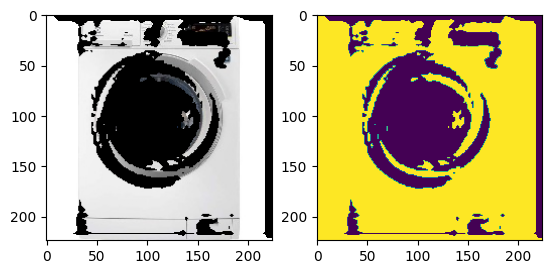

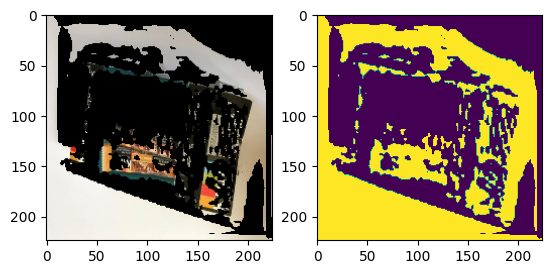

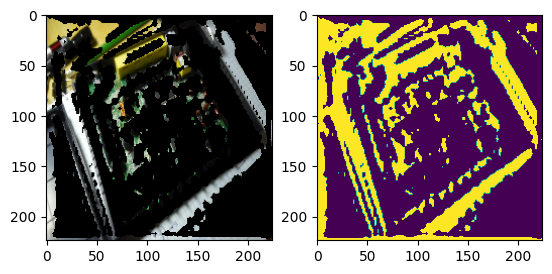

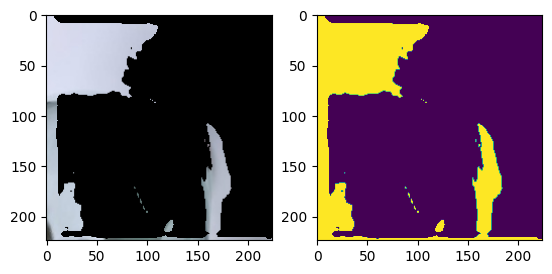

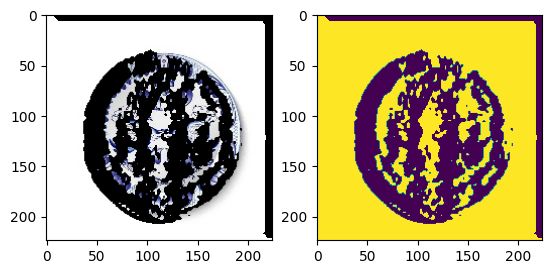

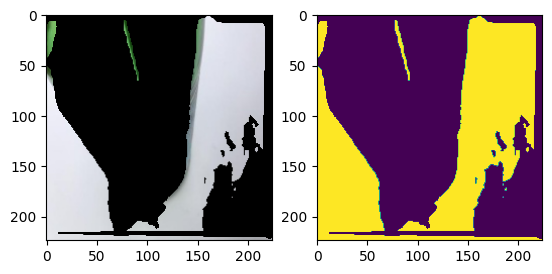

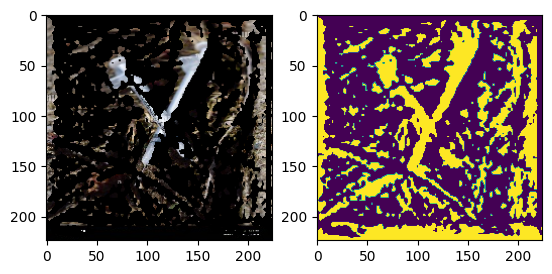

KeyboardInterrupt: 

In [13]:
for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device=cuda), labels.to(device=cuda)
        
        with torch.set_grad_enabled(True):
            # get the points

            output = custom(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Print loss every 10 iterations
        if i % 10 == 0:
            print(f'Epoch: {epoch} | Iteration: {i} | Loss: {loss.item()}')
        